# Introduction

Goal of this notebook is to explore technique called `cascade` that is designed for highly imbalanced data. This technique is based on cascade of multiple classifiers starting from ones with extremly high recall score that can pre-filter imbalanced data by identifying part of negative sequences. When model have a high recall, it means that that it can identifies all (or almost all) positive examples. Problem is that it will also makr many negative examples as positive (it will have many false positives). But we don't care about this in pre-filtering steps. 

# Setup

In [1]:
!pip install -q tensorflow
!pip install -q tensorflow_addons

# Model architecture

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.layers import (
                                BatchNormalization, LeakyReLU,
                                Input, Dense, Conv2D,
                                MaxPooling2D, Flatten, Dropout)
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa


def one_hot_encoding(df, tensor_dim=(50, 20, 1)):
    """
    fun transform input database to numpy array.
    
    parameters:
    df = Pandas df with col names "gene", "label", "miRNA"
    tensor_dim= 2d matrix shape
    
    output:
    2d dot matrix, labels as np array
    """
    df.reset_index(inplace=True, drop=True)

    # alphabet for watson-crick interactions.
    alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1.}

    # labels to one hot encoding
    label = df["label"].to_numpy()

    # create empty main 2d matrix array
    N = df.shape[0]  # number of samples in df
    shape_matrix_2d = (N, *tensor_dim)  # 2d matrix shape
    # initialize dot matrix with zeros
    ohe_matrix_2d = np.zeros(shape_matrix_2d, dtype="float32")

    # compile matrix with watson-crick interactions.
    for index, row in df.iterrows():
        for bind_index, bind_nt in enumerate(row.gene.upper()):

            for mirna_index, mirna_nt in enumerate(row.miRNA.upper()):

                base_pairs = bind_nt + mirna_nt
                ohe_matrix_2d[index, bind_index, mirna_index, 0] = alphabet.get(base_pairs, 0)

    return ohe_matrix_2d, label


def make_architecture():
    """
    build model architecture

    return a model object
    """
    main_input = Input(shape=(50, 20, 1),
                       dtype='float32', name='main_input'
                       )

    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_1")(main_input)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_1')(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_2")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_2')(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_3")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_3')(x)
    x = Dropout(rate=0.25)(x)

    conv_flat = Flatten(name='2d_matrix')(x)

    x = Dense(128)(conv_flat)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)

    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)

    x = Dense(32)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)

    main_output = Dense(1, activation='sigmoid', name='main_output')(x)

    m = K.Model(inputs=[main_input], outputs=[main_output], name='arch_00')

    return m

METRICS = [
      K.metrics.TruePositives(name='tp'),
      K.metrics.FalsePositives(name='fp'),
      K.metrics.TrueNegatives(name='tn'),
      K.metrics.FalseNegatives(name='fn'), 
      K.metrics.BinaryAccuracy(name='accuracy'),
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      K.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def compile_model(metrics=METRICS):
    K.backend.clear_session()
    m = make_architecture()

    opt = Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam")

    m.compile(
        optimizer=opt,
        loss=tfa.losses.SigmoidFocalCrossEntropy(),
        metrics=metrics
        )
    return m


def plot_history(history):
    """
    plot history of the training of the model,
    accuracy and loss of the training and validation set
    """

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6), dpi=80)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Recall')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()


2022-04-27 08:25:55.734227: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 08:25:56.805829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43672 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:27:00.0, compute capability: 8.6


# Train data 1:10 preparation

In [3]:
training_ratio = 10
train_df = pd.read_csv("../data/train_set_1_" + str(training_ratio) + "_CLASH2013_paper.tsv", sep='\t')
# set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
train_df = train_df.sample(frac=1, random_state=RANDOM_STATE)
print(train_df.head())
ohe_data = one_hot_encoding(train_df)
train_ohe, train_labels = ohe_data

                       miRNA  \
45236   ACTGCATTATGAGCACTTAA   
168824  TATTGCACTTGTCCCGGCCT   
2591    AAAAGCTGGGTTGAGAGGGC   
76746   TCTCACACAGAAATCGCACC   
63277   TGAGGTAGTAGTTTGTGCTG   

                                                     gene  label  
45236   GAGAAGAAATCTGGCTGGTTTGAGGGTTTCCTTTAGTTCACCCTCA...      0  
168824  GTAAATGTCTGTTTTTCATAATTGCTCTTTATATTGTGTGTTATCT...      0  
2591    GTACCCAGTAAAAACCAGAATGACCCATTGCCAGGACGCATCAAAG...      1  
76746   ACGTCGGCGCCATGCTCCAGGTACAGAGCCACATGTTGCTCCAGGC...      0  
63277   ACCAATGCCAGAGGAGCAACAGCGGCAACCTTTGGCACTGCATCCA...      0  


In [4]:
print("Number of samples: ", train_df.shape[0])
print("Positives: ", np.sum(train_labels == 1))
print("Negatives: ", np.sum(train_labels == 0))

Number of samples:  169312
Positives:  15392
Negatives:  153920


# Creating model

In [8]:
model = compile_model()
#model.summary()

# Model focused on recall

## Train subsampler

Epoch 1/20
5027/5027 [==============================] - 80s 16ms/step - loss: 0.3693 - tp: 15705.0000 - fp: 93149.0000 - tn: 78225.0000 - fn: 1415.0000 - accuracy: 0.4983 - precision: 0.1443 - recall: 0.9173 - auc: 0.8122 - prc: 0.3026 - val_loss: 0.0838 - val_tp: 670.0000 - val_fp: 1436.0000 - val_tn: 6258.0000 - val_fn: 102.0000 - val_accuracy: 0.8183 - val_precision: 0.3181 - val_recall: 0.8679 - val_auc: 0.9225 - val_prc: 0.6700
Epoch 2/20
5027/5027 [==============================] - 75s 15ms/step - loss: 0.2526 - tp: 13692.0000 - fp: 56851.0000 - tn: 89375.0000 - fn: 928.0000 - accuracy: 0.6408 - precision: 0.1941 - recall: 0.9365 - auc: 0.8997 - prc: 0.5454 - val_loss: 0.1538 - val_tp: 753.0000 - val_fp: 3204.0000 - val_tn: 4490.0000 - val_fn: 19.0000 - val_accuracy: 0.6193 - val_precision: 0.1903 - val_recall: 0.9754 - val_auc: 0.9434 - val_prc: 0.7381
Epoch 3/20
5027/5027 [==============================] - 73s 15ms/step - loss: 0.2252 - tp: 13783.0000 - fp: 47026.0000 - tn: 992

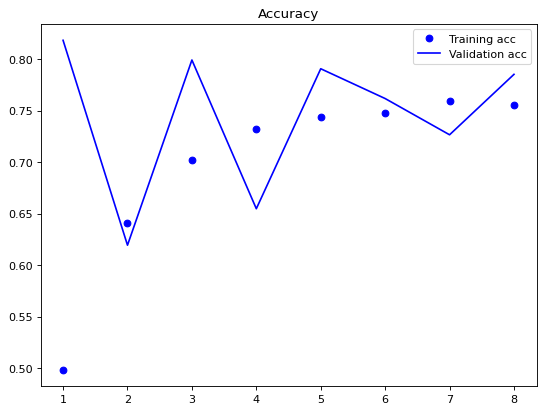

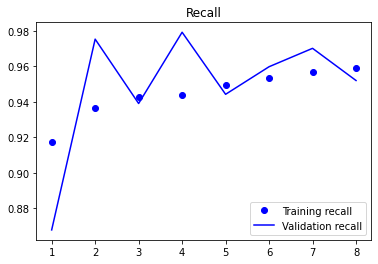

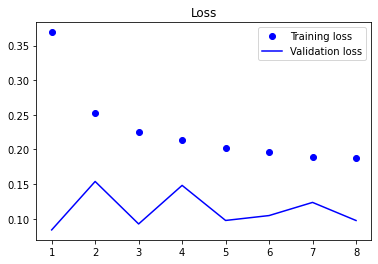

AttributeError: 'Functional' object has no attribute 'load'

In [9]:
monitor_val_recall = EarlyStopping(monitor = 'val_recall', patience = 7)
best_model_path = "model_1_" + str(training_ratio) + "focal.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_recall',
    mode='max',
    save_best_only=True)
model_history = model.fit(
    train_ohe, train_labels,
    validation_split=0.05, epochs=20,
    batch_size=32,
    class_weight={0: 1, 1: 10*training_ratio},
    callbacks=[monitor_val_recall, model_checkpoint_callback]
    )

plot_history(model_history)

#model.save("model_1_" + str(training_ratio) + "focal.h5")

In [11]:
model.load_weights(best_model_path)

## Subsample training data

In [12]:
predictions = model.predict(train_ohe)

In [13]:
predictions_df = pd.DataFrame(np.array([predictions[:,0], train_labels]).T, columns=['preds', 'labels'])
predictions_df

,preds,labels
0,0.424566,0.0
1,0.688316,0.0
2,0.741570,1.0
3,0.624676,0.0
4,0.391909,0.0
...,...,...
169307,0.473083,0.0
169308,0.719500,0.0
169309,0.480056,0.0
169310,0.457985,0.0


In [14]:
threshold = 0.4

predictions_sub = predictions_df[predictions_df['preds'] > threshold]['preds']
train_ohe_sub = train_ohe[predictions_df[predictions_df['preds'] > threshold].index]
train_labels_sub = train_labels[predictions_df[predictions_df['preds'] > threshold].index]

In [15]:
print("Number of samples: ", len(train_labels_sub))
print("Positives: ", np.sum(train_labels_sub == 1))
print("Negatives: ", np.sum(train_labels_sub == 0))

Number of samples:  107557
Positives:  15303
Negatives:  92254


## Trian subsampler on subsampled data

In [16]:
model2 = compile_model()
#model2.summary()

Epoch 1/20
3193/3194 [============================>.] - ETA: 0s - loss: 0.3821 - tp: 13384.0000 - fp: 61932.0000 - tn: 33400.0000 - fn: 1926.0000 - accuracy: 0.4228 - precision: 0.1777 - recall: 0.8742 - auc: 0.7110 - prc: 0.2748
Epoch 1: val_recall improved from -inf to 0.85490, saving model to model2_1_10focal.ckpt
3194/3194 [==============================] - 45s 13ms/step - loss: 0.3821 - tp: 13384.0000 - fp: 61935.0000 - tn: 33400.0000 - fn: 1926.0000 - accuracy: 0.4228 - precision: 0.1777 - recall: 0.8742 - auc: 0.7110 - prc: 0.2748 - val_loss: 0.1105 - val_tp: 654.0000 - val_fp: 1470.0000 - val_tn: 3143.0000 - val_fn: 111.0000 - val_accuracy: 0.7060 - val_precision: 0.3079 - val_recall: 0.8549 - val_auc: 0.8710 - val_prc: 0.6275
Epoch 2/20
3191/3194 [============================>.] - ETA: 0s - loss: 0.2576 - tp: 13169.0000 - fp: 40787.0000 - tn: 46795.0000 - fn: 1361.0000 - accuracy: 0.5872 - precision: 0.2441 - recall: 0.9063 - auc: 0.8528 - prc: 0.5691
Epoch 2: val_recall impro

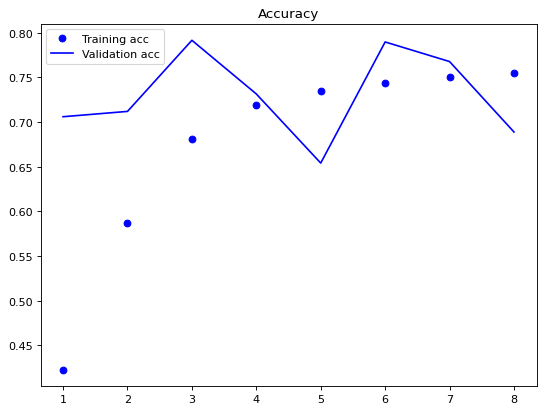

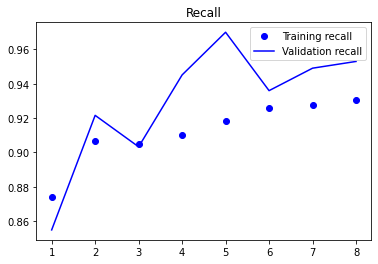

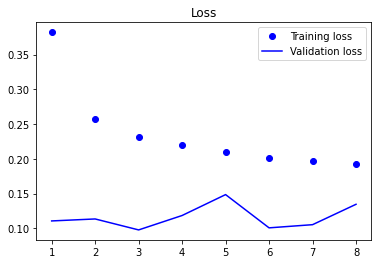

In [17]:
monitor_val_loss = EarlyStopping(monitor = 'val_loss', patience = 7)
best_model_path = "model2_1_" + str(training_ratio) + "focal.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=1)
model_history = model2.fit(
    train_ohe_sub, train_labels_sub,
    validation_split=0.05, epochs=20,
    batch_size=32,
    class_weight={0: 1, 1: 5*training_ratio},
    callbacks=[monitor_val_recall, model_checkpoint_callback]
    )

plot_history(model_history)

model2.load_weights("model2_1_" + str(training_ratio) + "focal.h5")

# Evaluate

In [247]:
from sklearn import metrics

def predict(model, ohe, labels, preds_df_prev):
    predictions = model.predict(ohe)
    
    preds_df_cur = pd.DataFrame(np.array([predictions[:,0], labels]).T, columns=['preds', 'labels'])
    preds_df = pd.concat([preds_df_prev, preds_df_cur])
    
    plt.figure(figsize=(4, 4), dpi=250)
    precision, recall, threshold = precision_recall_curve(preds_df['labels'].astype(int), preds_df['preds'])
    print("Auc", metrics.auc(recall, precision))
    plt.plot(recall, precision, label='miRBind', marker=',', color='#73a2c6')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    return preds_df_cur

In [249]:
def subsample(preds_df_prev, preds_df_cur, ohe, low_threshold, high_threshold):
    
    ohe_sub = ohe[preds_df_cur[(preds_df_cur['preds'] > low_threshold) & (preds_df_cur['preds'] < high_threshold)].index]
    labels_sub = preds_df_cur['labels'][(preds_df_cur['preds'] > low_threshold) & (preds_df_cur['preds'] < high_threshold)].index]
    preds_df_cur_sub = preds_df_cur[(preds_df_cur['preds'] <= low_threshold) & (preds_df_cur['preds'] >= high_threshold)]
    
    preds_df_prev = pd.concat([preds_df_prev, preds_df_cur_sub])
    
    print("Number of samples: ", len(labels_sub))
    print("Positives: ", np.sum(labels_sub == 1))
    print("Negatives: ", np.sum(labels_sub == 0))
    
    return ohe_sub, labels_sub, preds_df_prev

## Predictiona by model trained on 1:10 with focus on recall

In [250]:
dataset_ratio = '10'
df = pd.read_csv("../data/evaluation_set_1_" + dataset_ratio + "_CLASH2013_paper.tsv", sep='\t')
ohe_data = one_hot_encoding(df)
test_ohe, test_labels = ohe_data

In [251]:
print("Number of samples: ", df.shape[0])
print("Positives: ", np.sum(test_labels == 1))
print("Negatives: ", np.sum(test_labels == 0))

Number of samples:  11000
Positives:  1000
Negatives:  10000


In [252]:
preds_df_prev = pd.DataFrame([], columns=['preds', 'labels'])
preds_df_prev

,preds,labels


Auc 0.7646639074315561


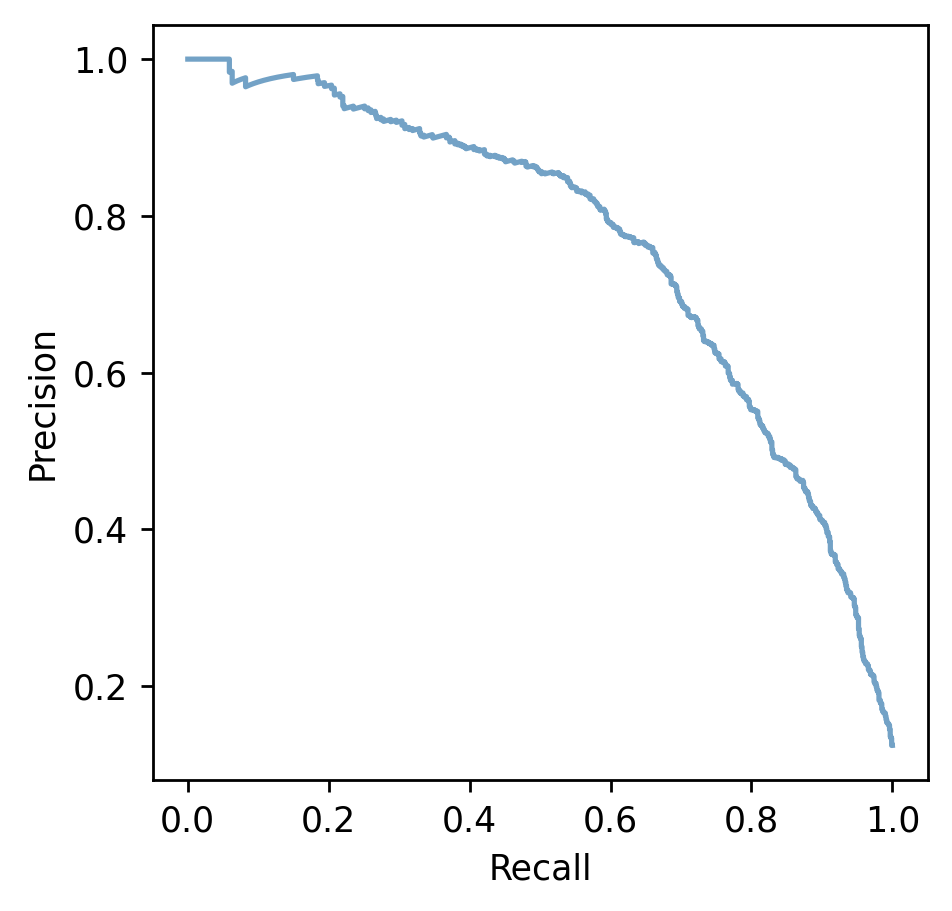

In [253]:
preds_df_cur = predict(model, test_ohe, test_labels, preds_df_prev)
#predictions = model2.predict(test_ohe)
#preds_df_cur = pd.DataFrame(np.array([predictions[:,0], test_labels]).T, columns=['preds', 'labels'])
#preds_df = pd.concat([preds_df_prev, preds_df_cur])
#precision, recall, threshold = precision_recall_curve(preds_df['labels'].astype(int), preds_df['preds'])
#print("Auc", metrics.auc(recall, precision))
#plt.figure(figsize=(4, 4), dpi=250)
#plt.plot(recall, precision, label='miRBind', marker=',', color='#73a2c6');
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.show();
#plt.clf()
#plt.cla()
#plt.close()

In [254]:
from sklearn.metrics import precision_score, recall_score

def print_precision_recall(labels, model_10_recall_predictions, threshold = 0.5):
  recall = recall_score(labels, model_10_recall_predictions > threshold)
  precision = precision_score(labels, model_10_recall_predictions > threshold)

  print("  Precision: ",precision)
  print("  Recall: ", recall)

In [255]:
for threshold in [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]:
    print("Threshold: ", threshold)
    print_precision_recall(test_labels, preds_df_cur['preds'], threshold = threshold)

Threshold:  0.5
  Precision:  0.20324526731849385
  Recall:  0.977
Threshold:  0.4
  Precision:  0.14275486827033218
  Recall:  0.997
Threshold:  0.3
  Precision:  0.10387451958034694
  Recall:  1.0
Threshold:  0.2
  Precision:  0.09219138932423712
  Recall:  1.0
Threshold:  0.1
  Precision:  0.09090909090909091
  Recall:  1.0
Threshold:  0.05
  Precision:  0.09090909090909091
  Recall:  1.0


## Subsample data from 1:10 to aprox 1:5

In [256]:
test_ohe_sub, test_labels_sub, preds_df_prev = subsample(preds_df_prev, preds_df_cur, test_ohe, 0.4, 0.9)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

How to deal with evaluation on subsampled data? We need to somehow mark excluded samples as negatives (give them score `0` or score that was given by the model?) and continue scoring only rest of the samples. But we need to put them together for the evaluation.

What is the problem? I was not doing this at all. I was subsampling the data and labels as well. And then I was doing evaluation only on subsampled part. So I was evaluation on the different problem.

But how to put the results of multiple models together? When I naively subsample data by threshold score, I loose mapping to the original labels. That is why I was subsampling labels as well - I could map results to labels by the order. 

So I was thinking to sort original results before subsampling. I will cut at specific threshold and I will know that before that I already have a fixed predictions and after that I will do new predictions.

## Predictions by model trained on subsampled data

Auc 0.7814481308983698


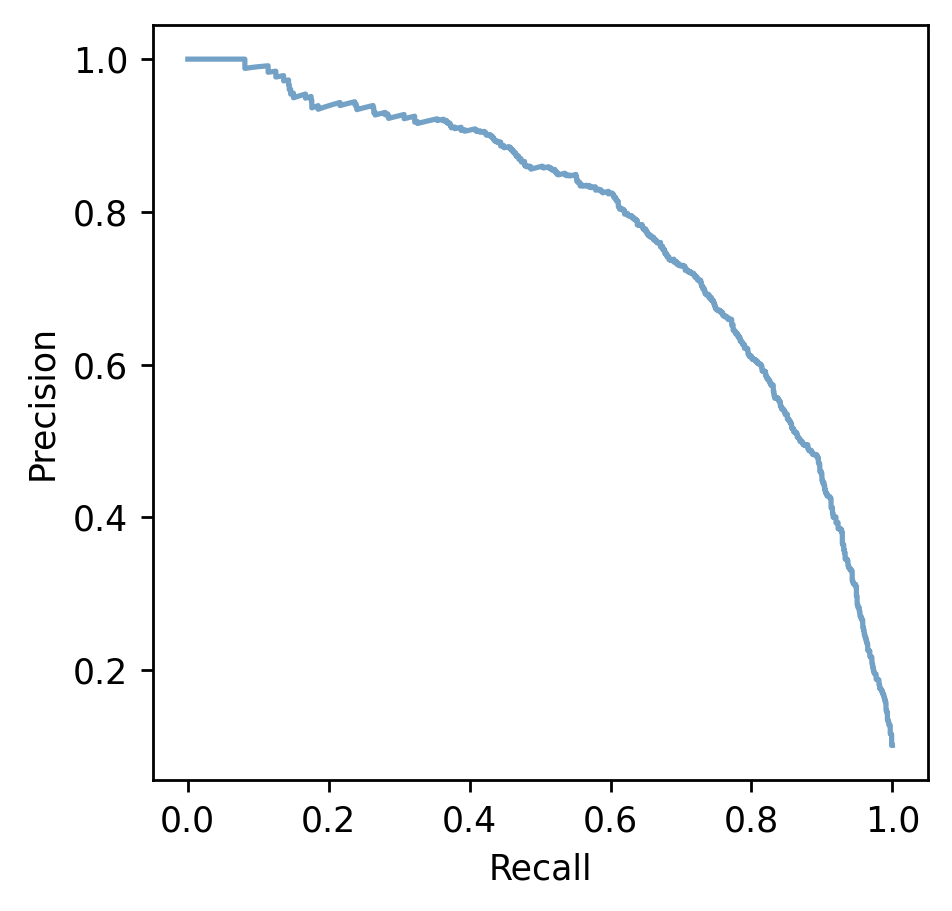

In [243]:
preds_df_cur = predict(model2, test_ohe_sub, test_labels_sub, preds_df_prev)
#print("Auc", metrics.auc(recall, precision))
#plt.figure(figsize=(4, 4), dpi=250)
#plt.plot(recall, precision, label='miRBind', marker=',', color='#73a2c6')
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.plot;

## Subsample data from 1:5 to aprox 

In [244]:
test_ohe_sub_sub, test_labels_sub_sub, preds_df_prev = subsample(preds_df_prev, preds_df_cur, test_ohe, 0.4)

Number of samples:  3433
Positives:  953
Negatives:  2480


## 1:1 model from Eva

Auc 0.8369818042374378


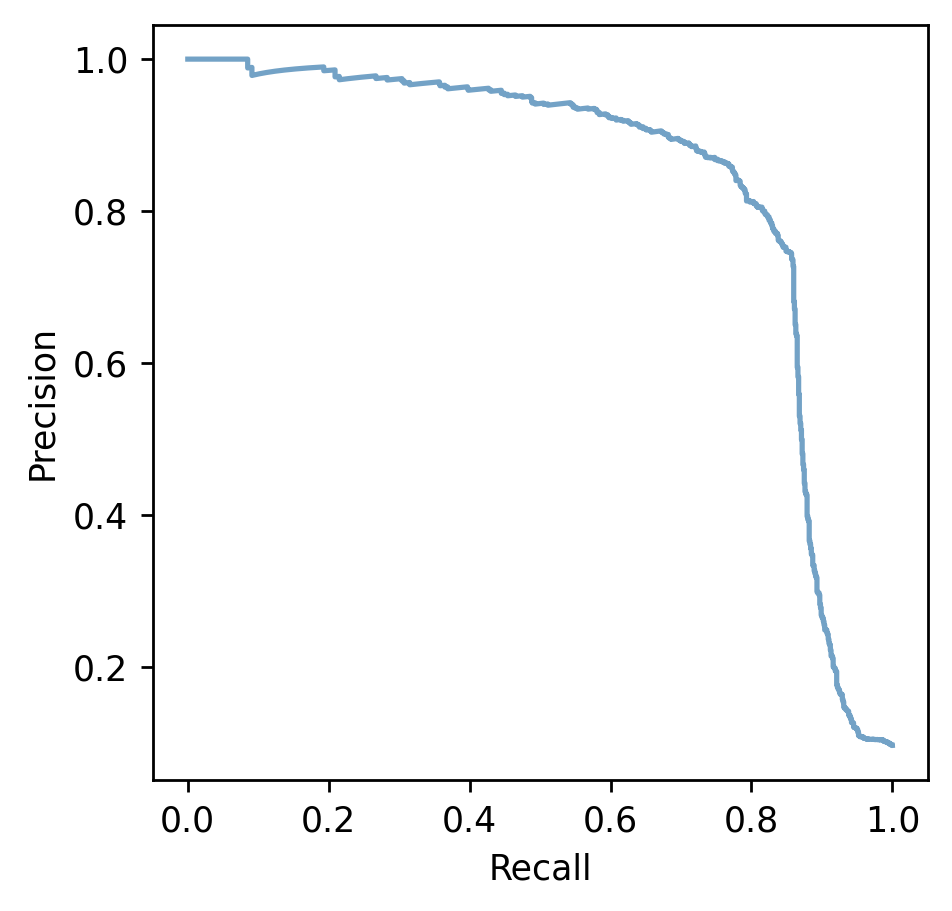

In [246]:
model_1 = K.models.load_model("../../miRBind/Models/model_1_10.h5")
preds_df_cur = predict(model_1, test_ohe_sub_sub, test_labels_sub_sub, preds_df_prev)